<a href="https://colab.research.google.com/github/Hyeok-Jun-Yoon/AI_Plus/blob/main/%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C_3%EC%A3%BC%EC%B0%A8_AI_2%EA%B8%B0_%EC%9C%A4%ED%98%81%EC%A4%80_MNLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-genre natural language inference(MNLI)

In [2]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This 

## [MYCODE] Kaggle Data 준비 (MultiNLI (Multi-Genre Natural Language Inference))

In [3]:
from google.colab import files
files.upload()  # 이 명령을 실행하면 파일을 업로드하는 창이 뜹니다.


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hueokjun","key":"71e8b4674cbd15c3edee7b9a8eb199e7"}'}

In [4]:
#kaggle.json을 올바른 경로에 저장
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [5]:
!kaggle datasets download -d thedevastator/unlocking-language-understanding-with-the-multin

Dataset URL: https://www.kaggle.com/datasets/thedevastator/unlocking-language-understanding-with-the-multin
License(s): CC0-1.0
 91% 100M/109M [00:01<00:00, 70.0MB/s] 
100% 109M/109M [00:01<00:00, 73.6MB/s]


In [6]:
!unzip unlocking-language-understanding-with-the-multin.zip -d /content/

Archive:  unlocking-language-understanding-with-the-multin.zip
  inflating: /content/train.csv      
  inflating: /content/validation_matched.csv  
  inflating: /content/validation_mismatched.csv  


premise:  첫 번째 문장 (전제)

premise_binary_parse:  문법적 요소들(주어, 동사, 목적어 등)과 그 관계

hypothesis: 두 번째 문장 (가설)

hypothesis_binary_parse:  문법적 요소와 그 관계를 트리 구조

genre: 해당 문장이 속하는 장르

label: 자연어 추론의 답. MNLI는 3개의 레이블을 사용
*   0: Contradiction (모순) - 가설이 전제와 모순됨
*   1: Entailment (함의) - 가설이 전제로부터 의미상 귀결됨
*   2: Neutral (중립) - 가설과 전제 간에 명확한 관계가 없음  





In [7]:
import pandas as pd

# 데이터셋 로드
data = pd.read_csv('/content/train.csv')
print(data.head())  # 데이터의 상위 5개 행 확인

   promptID   pairID                                            premise  \
0     31193   31193n  Conceptually cream skimming has two basic dime...   
1    101457  101457e  you know during the season and i guess at at y...   
2    134793  134793e  One of our number will carry out your instruct...   
3     37397   37397e  How do you know? All this is their information...   
4     50563   50563n  yeah i tell you what though if you go price so...   

                                premise_binary_parse  \
0  ( ( Conceptually ( cream skimming ) ) ( ( has ...   
1  ( you ( ( know ( during ( ( ( the season ) and...   
2  ( ( One ( of ( our number ) ) ) ( ( will ( ( (...   
3  ( ( How ( ( ( do you ) know ) ? ) ) ( ( All th...   
4  ( yeah ( i ( ( tell you ) ( what ( ( though ( ...   

                                       premise_parse  \
0  (ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...   
1  (ROOT (S (NP (PRP you)) (VP (VBP know) (PP (IN...   
2  (ROOT (S (NP (NP (CD One)) (PP (IN of) (N

## [MYCODE] Train_loader , Test_loader 정의

tokenizer를 불러옵니다.

In [8]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer

# DistilBERT 토크나이저 로드
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [54]:
ds = load_dataset('csv', data_files='/content/train.csv')

ds_label = load_dataset('csv', data_files='/content/validation_matched.csv')

train_data = ds['train'].select(range(10000))  # 첫 10,000개 샘플만 선택

print(train_data[0])
print(len(train_data))
print(ds_label['train'][0])

{'promptID': 31193, 'pairID': '31193n', 'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.', 'premise_binary_parse': '( ( Conceptually ( cream skimming ) ) ( ( has ( ( ( two ( basic dimensions ) ) - ) ( ( product and ) geography ) ) ) . ) )', 'premise_parse': '(ROOT (S (NP (JJ Conceptually) (NN cream) (NN skimming)) (VP (VBZ has) (NP (NP (CD two) (JJ basic) (NNS dimensions)) (: -) (NP (NN product) (CC and) (NN geography)))) (. .)))', 'hypothesis': 'Product and geography are what make cream skimming work. ', 'hypothesis_binary_parse': '( ( ( Product and ) geography ) ( ( are ( what ( make ( cream ( skimming work ) ) ) ) ) . ) )', 'hypothesis_parse': '(ROOT (S (NP (NN Product) (CC and) (NN geography)) (VP (VBP are) (SBAR (WHNP (WP what)) (S (VP (VBP make) (NP (NP (NN cream)) (VP (VBG skimming) (NP (NN work)))))))) (. .)))', 'genre': 'government', 'label': 1}
10000
{'promptID': 63735, 'pairID': '63735n', 'premise': 'The new rights are nice enough', '

In [60]:
def collate_fn(batch):
    max_len = 128  # 최대 길이를 설정 (BERT 기반 모델은 일반적으로 128 정도가 적당)
    texts, labels = [], []

    for row in batch:
        premise = row['premise']  # Premise
        hypothesis = row['hypothesis']  # Hypothesis
        label = row['label']  # 레이블

        # Premise와 Hypothesis 두 문장을 하나로 결합하여 토큰화
        text = f"{premise} [SEP] {hypothesis}"
        texts.append(text)
        labels.append(label)

    # 두 문장을 토큰화하고 padding 및 truncation 적용
    tokenizer_encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
    input_text = tokenizer_encodings['input_ids']
    masks = tokenizer_encodings['attention_mask'] #[MYCODE]학습 시 attention_mask를 사용하기 위함

    # 레이블을 Tensor로 변환
    labels = torch.tensor(labels)

    return input_text, labels, masks

# DataLoader 준비
train_loader = DataLoader(
   train_data, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds_label['train'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [61]:
for texts, labels, masks in train_loader:
  print(f"texts.shape : {texts.shape}")
  print(f"mask.shape : {masks.shape}")
  print(f"labels.shape : {labels.shape}")
  print(f"text :{texts}")
  print(f"mask : {masks}")
  print(f"labels : {labels}")
  break

texts.shape : torch.Size([64, 61])
mask.shape : torch.Size([64, 61])
labels.shape : torch.Size([64])
text :tensor([[  101,  2002,  7164,  ...,     0,     0,     0],
        [  101,  2417,  2056,  ...,     0,     0,     0],
        [  101, 20964,  2015,  ...,     0,     0,     0],
        ...,
        [  101,  2065,  2027,  ...,     0,     0,     0],
        [  101,  3565,  9103,  ...,     0,     0,     0],
        [  101,  2021,  2008,  ...,     0,     0,     0]])
mask : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
labels : tensor([0, 2, 1, 0, 2, 2, 0, 2, 1, 1, 1, 0, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 0, 2,
        2, 0, 2, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 0,
        2, 0, 0, 2, 1, 2, 1, 1, 0, 2, 1, 0, 2, 1, 1, 1])


In [62]:
for batch in train_loader:
  texts, labels, masks = batch
  outputs= torch.unique(labels)

num_labels = len(outputs)

# 두 문장간의 관계 0 : 모순 / 1 : 연결  / 2 : 무관
print(f"{outputs}  ouput_num : {num_labels}")

tensor([0, 1, 2])  ouput_num : 3


## [MYCODE] pre-trained DistilBERT 선언

In [63]:
from transformers import DistilBertForSequenceClassification

# DistilBERT 모델과 토크나이저 로드 (MNLI용으로 미리 학습된 모델을 사용)
model_name = 'distilbert-base-uncased'
encoder_model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
encoder_model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [102]:
from torch import nn

class TextClassifier(nn.Module):
  def __init__(self,encoder_model,num_labels):
    super().__init__()

    self.encoder = encoder_model
    self.classifier = nn.Linear(768, num_labels)

  def forward(self, x, masks, labels=None):
    x = self.encoder(x, masks)
    x = x.logits  # 이미 logits를 반환하므로 추가 선형 레이어 필요 없음

    # DistilBertForSequenceClassification 모델에서 손실을 계산하려면 labels가 필요합니다

    # labels가 있을 경우 손실 계산
    if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        # CrossEntropyLoss는 x와 labels를 받아서 손실을 계산
        loss = loss_fct(x, labels)
        return loss, x  # loss와 logits를 반환

    return x # 추론 시에는 logits만 반환

model = TextClassifier(encoder_model,num_labels)

In [45]:
# 모든 파라미터 fine-tuning 학습 시간이 길어지지만, 더 높은 성능을 얻기 위함
#for param in model.encoder.parameters():
#  param.requires_grad = True

In [103]:
# DistilBERT 인코더 레이어만 동결
for param in model.encoder.base_model.parameters():  # DistilBERT 모델의 파라미터 고정
    param.requires_grad = False  # Transformer 레이어(인코더) 고정

# classifier는 fine-tuning을 위해 학습 가능
for param in model.classifier.parameters():
    param.requires_grad = True  # 최상위 분류 레이어 학습 가능

In [104]:
model

TextClassifier(
  (encoder): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): DistilBertSdpaAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          

## [MYCODE][LOG] 모델 학습 및 loss,acc 출력

In [105]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

lr = 1e-5
model = model.to('cuda')
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 20
train_loss = []
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    optimizer.zero_grad()  # 기울기 초기화
    inputs, labels, masks = data
    inputs, labels, masks = inputs.to('cuda'), labels.to('cuda'), masks.to('cuda')

    loss, preds = model(inputs, masks, labels)  # labels를 파라미터로 전달
    loss.backward()  # 기울기 계산
    optimizer.step()  # 파라미터 업데이트

    total_loss += loss.item()  # 총 손실 누적
  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  # train_loss에 각 에포크의 총 손실 기록
  train_loss.append(total_loss)

Epoch   0 | Train Loss: 164.49968284368515
Epoch   1 | Train Loss: 164.08108133077621
Epoch   2 | Train Loss: 164.0259764790535
Epoch   3 | Train Loss: 163.69516223669052
Epoch   4 | Train Loss: 163.53312420845032
Epoch   5 | Train Loss: 163.40729463100433
Epoch   6 | Train Loss: 163.22416239976883
Epoch   7 | Train Loss: 162.7345786690712
Epoch   8 | Train Loss: 162.78880268335342
Epoch   9 | Train Loss: 162.5686473250389
Epoch  10 | Train Loss: 162.2969366312027
Epoch  11 | Train Loss: 162.19241774082184
Epoch  12 | Train Loss: 162.10829412937164
Epoch  13 | Train Loss: 161.6512258052826
Epoch  14 | Train Loss: 161.83949476480484
Epoch  15 | Train Loss: 161.52010530233383
Epoch  16 | Train Loss: 161.2313432097435
Epoch  17 | Train Loss: 161.06504690647125
Epoch  18 | Train Loss: 161.1182872056961
Epoch  19 | Train Loss: 160.88670629262924


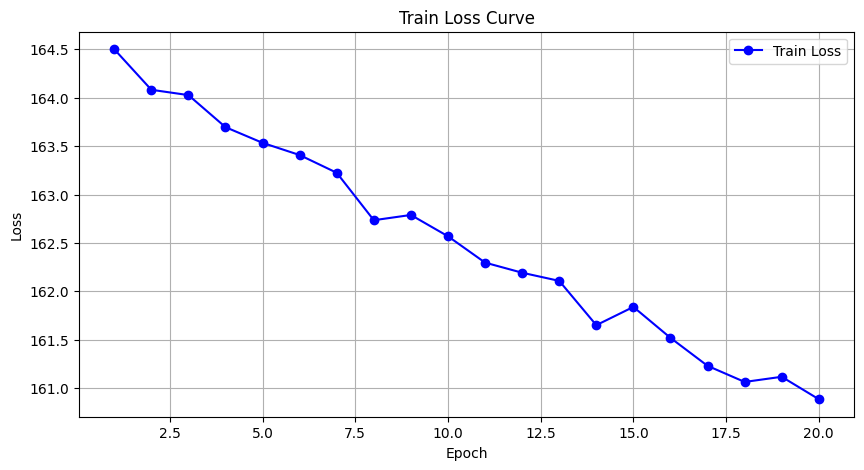

In [106]:
# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs+1), train_loss, label='Train Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels, masks = data
    inputs, labels, masks = inputs.to('cuda'), labels.to('cuda'), masks.to('cuda')

    preds = model(inputs, masks)
    preds = torch.argmax(preds, dim=-1)
    #preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()
  return (acc / cnt) * 100


with torch.no_grad():
  model.eval()
  pre_train_accuracies = accuracy(model, train_loader)
  pre_test_accuracies = accuracy(model, test_loader)
  print(f"=========> Train acc: {pre_train_accuracies:.3f} | Test acc: {pre_test_accuracies:.3f}")

=========> Train acc: 50.630 | Test acc: 46.072


## [MYCODE][LOG] Pre-train 하지 않는 transformer를 만들기 위해 기존 모델 초기화

In [116]:
from transformers import DistilBertConfig, DistilBertModel


# 기본 설정으로 DistilBERT 모델 초기화 (pre-trained 모델을 로드하지 않음)
config = DistilBertConfig()  # 기본 설정으로 초기화 (pre-trained X)
non_pretrained_model = DistilBertModel(config)  # non-pre-trained 모델

# 최상위 분류 레이어 정의
class TextClassifierNonPretrained(nn.Module):
    def __init__(self, encoder_model, num_labels):
        super().__init__()
        self.encoder = encoder_model
        self.classifier = nn.Linear(768, num_labels)  # 768은 DistilBERT의 hidden_size입니다.

        # non-pre-trained 모델을 사용할 때는, 모델의 파라미터를 학습 가능하도록 두기
        for param in self.encoder.parameters():
            param.requires_grad = True  # non-pre-trained 모델이므로 학습 가능

        # classifier 레이어만 fine-tuning하려면 해당 파라미터도 학습 가능
        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, x, masks, labels=None):
        x = self.encoder(x, attention_mask=masks)
        logits = x.last_hidden_state[:, 0, :]  # 첫 번째 토큰([CLS])의 임베딩 사용

        # labels가 있을 경우 손실 계산
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return loss, logits  # 손실과 logits 반환

        return logits  # 추론 시에는 logits만 반환

# 모델 인스턴스화
non_pretrained_model = TextClassifierNonPretrained(non_pretrained_model, num_labels)


In [117]:
non_pretrained_model

TextClassifierNonPretrained(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
           

In [118]:
lr = 1e-3
non_pretrained_model = non_pretrained_model.to('cuda')
non_pretrained_optimizer = Adam(non_pretrained_model.parameters(), lr=lr)
nonpre_train_loss = []
n_epochs = 30
for epoch in range(n_epochs):
  total_loss = 0.
  non_pretrained_model.train()
  for data in train_loader:
    non_pretrained_optimizer.zero_grad()  # 기울기 초기화
    inputs, labels, masks = data
    inputs, labels, masks = inputs.to('cuda'), labels.to('cuda'), masks.to('cuda')

    loss, preds = non_pretrained_model(inputs, masks, labels)  # labels를 파라미터로 전달
    loss.backward()  # 기울기 계산
    non_pretrained_optimizer.step()  # 파라미터 업데이트

    total_loss += loss.item()  # 총 손실 누적
  print(f"Epoch {epoch:3d} | nonpre_train_Loss: {total_loss}")

  # train_loss에 각 에포크의 총 손실 기록
  nonpre_train_loss.append(total_loss)

Epoch   0 | nonpre_train_Loss: 243.9597487449646
Epoch   1 | nonpre_train_Loss: 177.44820976257324
Epoch   2 | nonpre_train_Loss: 175.68247973918915
Epoch   3 | nonpre_train_Loss: 175.52556884288788
Epoch   4 | nonpre_train_Loss: 174.2263902425766
Epoch   5 | nonpre_train_Loss: 175.2445751428604
Epoch   6 | nonpre_train_Loss: 174.82529711723328
Epoch   7 | nonpre_train_Loss: 173.70104920864105
Epoch   8 | nonpre_train_Loss: 173.6149948835373
Epoch   9 | nonpre_train_Loss: 174.3157241344452
Epoch  10 | nonpre_train_Loss: 173.8158836364746
Epoch  11 | nonpre_train_Loss: 173.1204718351364
Epoch  12 | nonpre_train_Loss: 173.41392862796783
Epoch  13 | nonpre_train_Loss: 173.32401883602142
Epoch  14 | nonpre_train_Loss: 173.08777701854706
Epoch  15 | nonpre_train_Loss: 172.84826040267944
Epoch  16 | nonpre_train_Loss: 173.0362958908081
Epoch  17 | nonpre_train_Loss: 173.52312433719635
Epoch  18 | nonpre_train_Loss: 172.8615062236786
Epoch  19 | nonpre_train_Loss: 173.30408465862274
Epoch  20

##[MYCODE] Pre-trained vs Non Pre-trained Loss Comparison


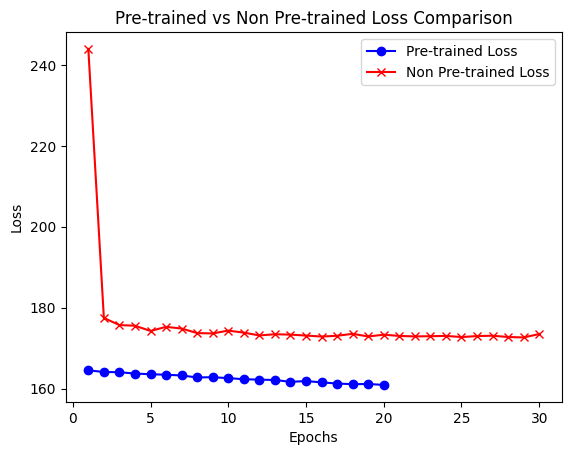

In [126]:
# 그래프 그리기
plt.plot(range(1, n_epochs-9), train_loss, label='Pre-trained Loss', color='blue', marker='o')
plt.plot(range(1, n_epochs+1), nonpre_train_loss, label='Non Pre-trained Loss', color='red', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Pre-trained vs Non Pre-trained Loss Comparison')
plt.legend()
plt.show()

## [MYCODE] Train vs Test Accuracy for Pre-trained and Non Pre-trained Models

In [127]:
with torch.no_grad():
  non_pretrained_model.eval()
  non_pre_train_acc = accuracy(non_pretrained_model, train_loader)
  non_pre_test_acc = accuracy(non_pretrained_model, test_loader)
  print(f"=========> Train acc: {non_pre_train_acc:.3f} | Test acc: {non_pre_test_acc:.3f}")

=========> Train acc: 36.860 | Test acc: 32.736


non-pre-trained 한 모델을 학습할때에는 확실히 학습 시간도 오래걸리고 성능이 떨어진다는 것을 알게되었습니다. lr 에도 영향을 많이 받는 것으로 보여 lr 값에 따라 trainloss 값이 차이가 많이 나는 걸 확인했습니다.